In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Clean and standardize the data

In [6]:
file_path = "ufo_data.csv"
df = pd.read_csv(file_path)

df_dropped_nas = df.dropna(subset=["shape", "duration", "occurred_date_time"])


# Cleaning function takes in dataframe, column, and patterns to filter out worthless and/or inconsistent values
# Function also standardizes the date and filters out the time in "occurred_date_time" column
def clean_dataframe(df, column_name, patterns):
    for pattern in patterns:
        df = df[~df[column_name].str.contains(pattern, regex=True, na=False)]

    df[column_name] = pd.to_datetime(df[column_name], errors="coerce", format="%m/%d/%y %H:%M")

    df = df.dropna(subset=[column_name])

    df[column_name] = df[column_name].dt.strftime('%m/%d/%y')
    
    return df

column_name = "occurred_date_time"
patterns = [r'\?', r'unknown', r'&', r'ongoing']

df_cleaned_dates = clean_dataframe(df_dropped_nas, column_name, patterns)

# Cleaning function to standardize time measurement in "duration" column to seconds
def clean_duration(df, column_name, filter_values):
    pattern = "|".join(filter_values)
    df_cleaned = df[~df[column_name].str.contains(pattern, case=False, na=False)]

    def convert_to_seconds(duration):
    
        duration = duration.lower()

        match = re.match(r'(\d+)\s*(seconds|minutes|hours?)', duration)

        if match:
            value = int(match.group(1))
            unit = match.group(2)

            if 'second' in unit:
                return value
            elif 'minute' in unit:
                return value * 60
            elif 'hour' in unit:
                return value * 3600
        return None
        
    df_cleaned.loc[:, column_name] = df_cleaned[column_name].apply(convert_to_seconds)
    df_cleaned = df_cleaned.dropna(subset=[column_name])
    return df_cleaned

filter_values = ["months", "years", "constant", "few", "ongoing"]

df_cleaned_duration = clean_duration(df_cleaned_dates, "duration", filter_values)

# Cleaning function to filter out non-US locations
def clean_city(df, column_name, filter_values):
    pattern = "|".join(filter_values)
    df = df[~df[column_name].str.contains(pattern, case=False, regex=True, na=False)]

    df = df.dropna(subset=[column_name])

    return df

city_filters = ["(Canada)", "(Portugal)", "(Spain)", "(Germany)", "(UK)", "(England)", "(Brazil)", "(Ecuador)", 
                "(Estonia)", "(Puerto Rico)", "(South Africa)", "(France)", "(Philippines)", "(Nigeria)", 
                "(Holland)", "(Australia)", "(Ireland)", "(Colombia)", "(Scotland)", "(Cyprus)", "(South Korea)",
                "(Norway)", "(Croatia)", "(Italy)", "(Singapore)", "(Chile)", "(Malta)", "(Greece)", "(Syria)", 
                "(Sweden)", "(Kyrgyzstan)", "(Myanmar)", "(Japan)", "(Mexico)", "(Argentina)", "(Egypt)", "(Poland)",
                "(Turkey)", "(Iraq)", "(India)", "(Jamaica)", "(Malaysia)", "(Venezuela)", "(Israel)", "(Kosovo)", 
                "(Belize)", "(Belgium)", "(Jordan)", "(Costa Rica)", "(Netherlands)", "(The Netherlands)", "(New Zealand)",
                "(Corsica)", "(in former Yugoslavia)", "(Bahamas)", "(location unspecified)", "(Serbia)", "(Iran)", "(Pakistan)", 
                "(Finland)", "(Botswana)", "(Dominican Republic)", r"\?", "(Saudi Arabia)", "(Indonesia)", "(Denmark)", "(Cambodia)",
                "(Russia)", "(China)"] 

df_cleaned_city = clean_city(df_cleaned_duration, "city", city_filters)

# one last NaN drop
df_cleaned_city.dropna()

# standardize capitalization
df_cleaned_city['shape'] = df_cleaned_city['shape'].str.lower()
df_cleaned_city['state'] = df_cleaned_city['state'].str.upper()

output_path = "cleaned_data.csv"
df_cleaned_city.to_csv(output_path, index=False)

C:\Users\kylea\AppData\Local\Temp\ipykernel_19772\2871780080.py:60: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df[column_name].str.contains(pattern, case=False, regex=True, na=False)]


### Calculate basic statistics

In [14]:
# import cleaned dataset
cleaned_file_path = "cleaned_data.csv"
df = pd.read_csv(cleaned_file_path)

# Mean, median, and mode of duration
mean_duration = df['duration'].mean().round(2)
median_duration = df['duration'].median()
mode_duration = df['duration'].mode()[0]

print(f"Mean duration: {mean_duration}")
print(f"Median duration: {median_duration}")
print(f"Mode duration: {mode_duration}")
print("\n")

# Mean duration for each state
state_group = df.groupby('state')['duration'].mean()
print(state_group)

# Find outlier durations using interquartile range method

# get q1 and q3
q1 = df['duration'].quantile(0.25)
q3 = df['duration'].quantile(0.75)

# get iqr
iqr = q3 - q1

# get upper and lower bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# get outliers
outliers = df[(df['duration'] < lower_bound) | (df['duration'] > upper_bound)]
print(outliers.describe())

Mean duration: 939.48
Median duration: 240.0
Mode duration: 300.0


state
AB     346.800000
AK    1165.343860
AL    1003.588968
AR     950.639640
AZ    1181.462838
BC     257.444444
CA     846.900236
CO     890.937357
CT     938.001211
DC     552.078125
DE     686.480874
FL     940.459169
GA     949.660777
HI     977.922819
IA     765.671488
ID     973.246296
IL     749.610644
IN     852.385051
KS    1086.006369
KY    1036.077266
LA     771.297539
MA     893.998214
MB    8510.000000
MD     851.558999
ME    1105.088843
MI     905.207819
MN     984.921171
MO     903.386835
MS    1171.382838
MT    1108.045977
NB      40.000000
NC     904.814532
ND     861.902439
NE    1084.672794
NH     897.764000
NJ     825.540116
NM    1287.278891
NS      10.000000
NV    1255.871942
NY     823.778329
OH    1067.525853
OK    1260.429293
ON     480.000000
OR     953.738947
PA    1036.447739
RI     706.211155
SC     854.777336
SD    1214.745223
SK     960.000000
TN    1190.494737
TX     931.462020
UT    11

In [12]:
# Most commonly reported shape
most_common_shape = df['shape'].value_counts().idxmax()
most_common_shape_count = df['shape'].value_counts().max()

print(f"The most commonly reported shape is {most_common_shape} with {most_common_shape_count} reports")
print("\n")

# count of all reported shapes
shape_counts = df['shape'].value_counts()
print(f"{shape_counts}")

The most commonly reported shape is light with 11577 reports


shape
light        11577
circle        6195
triangle      5193
fireball      4597
sphere        3878
unknown       3718
other         3585
disk          3023
oval          2473
formation     1792
changing      1362
cigar         1311
rectangle      947
flash          946
cylinder       877
diamond        829
chevron        723
teardrop       477
egg            469
cone           207
cross          172
delta            3
flare            1
changed          1
Name: count, dtype: int64


In [8]:
# most reports per state

most_common_state = df['state'].value_counts().idxmax()
most_common_state_count = df['state'].value_counts().max()

print(f"{most_common_state} has the most reported sightings with {most_common_state_count} total sightings")

# sightings per state

state_counts = df['state'].value_counts()

print(f"{state_counts}")

CA has the most reported sightings with 6766 total sightings
state
CA    6766
FL    3441
WA    2733
NY    2418
TX    2396
AZ    2072
PA    2057
OH    1818
IL    1785
NC    1569
MI    1458
OR    1425
CO    1309
NJ    1209
VA    1170
GA    1132
MA    1120
MO    1109
SC    1006
TN     950
WI     948
MN     888
IN     883
MD     839
CT     826
NV     695
KY     673
NM     649
UT     598
OK     594
AL     562
ID     540
NH     500
ME     484
IA     484
KS     471
LA     447
AR     444
MT     435
WV     392
MS     303
HI     298
AK     285
NE     272
VT     271
RI     251
DE     183
WY     170
SD     157
ND     123
DC      64
AB      10
BC       9
ON       8
MB       3
SK       2
YT       1
NS       1
NB       1
Name: count, dtype: int64


### Basic plots

C:\Users\kylea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


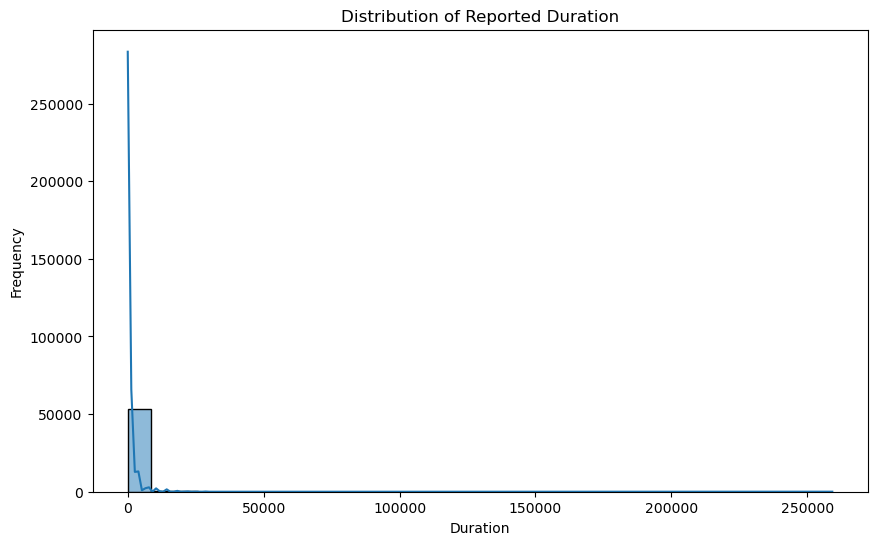

skewness 36.3272183601117


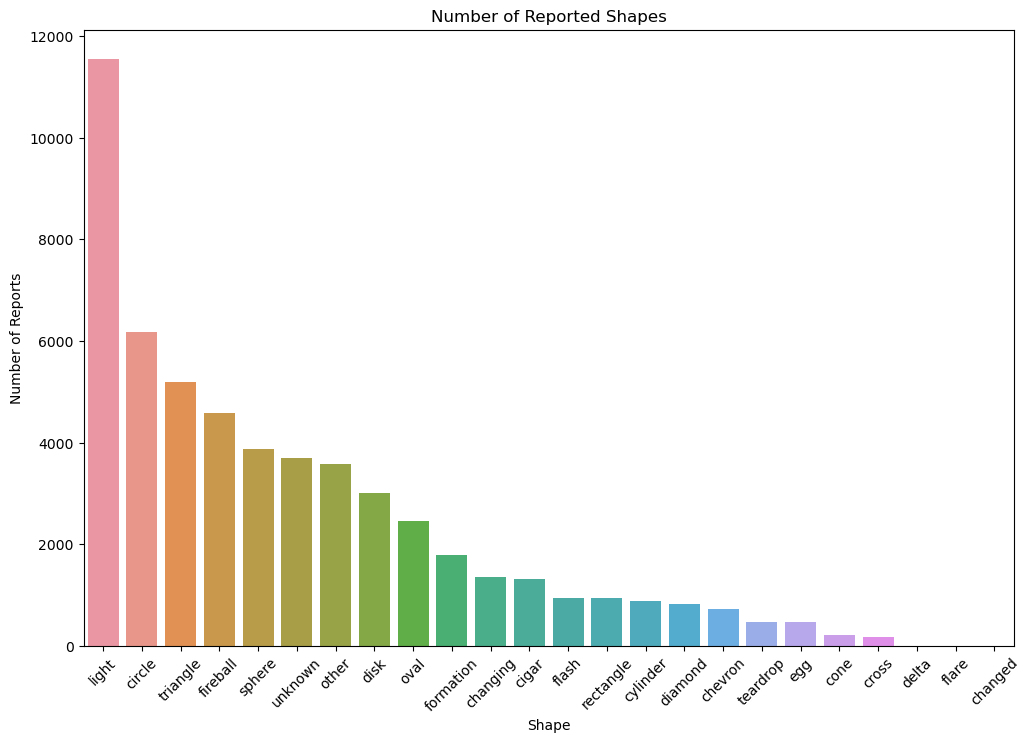

In [15]:
# Histogram of reported duration

plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=30, kde=True)
plt.title('Distribution of Reported Durations')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.savefig('plots/durationHistogram.png')
plt.show()

# Histogram is very skewed, but how much exactly?
skewness = df['duration'].skew()
print("skewness", skewness)
# 36. HIGHLY skewed duration data!!!!

# Bar plot of reported shapes

plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='shape', order=df['shape'].value_counts().index)
plt.title("Number of Reported Shapes")
plt.xlabel('Shape')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.savefig('plots/shapeBarPlot.png')
plt.show()